## Chapter 5
# Detection Using Cross Correlation With Whistler Kernel

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

## **5.2 Kernels**

### **Kernel Extracted From Data**

**Generate Whistler Cuts**

In [10]:
from database import Database
from sample_detector import SampleDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
sample = SampleDetector(dataset_loc, site, np.random.choice(database.get_train(),1)[0])
transforms = []
transforms_params = []
cut_params=[0.8,0.3,9,1,0.1]
# database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
#                               cut_params=cut_params, verbose=True, noise=False, train=True, test=False)
X,Y = database.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
                              cut_params=cut_params, verbose=True, noise=False, test=False)
X_mean = X.mean(axis=0)#database.whistler_mean(transforms=transforms, transforms_params=transforms_params, cut_params=cut_params)

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/[]_[]_[0.8, 0.3, 9, 1, 0.1]_False/train
samples:  8318


100%|██████████| 8318/8318 [01:43<00:00, 80.44it/s] 


**Show examples of whistler cuts**

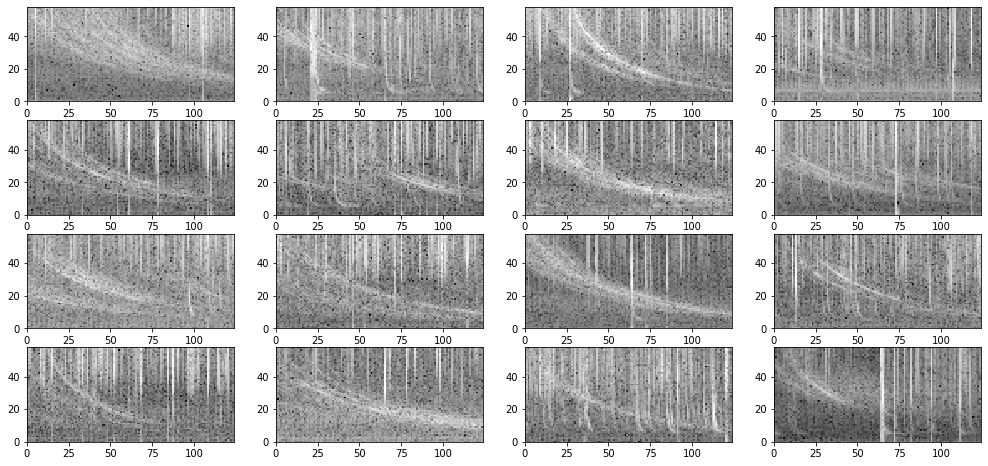

In [15]:
x_size, y_size, ix = 4,4,0
fig, axes = plt.subplots(x_size, y_size, figsize=(x_size*2*(X_mean.shape[1]/X_mean.shape[0]),y_size*2))
for x in range(x_size):
    for y in range(y_size):
        axes[x,y].pcolormesh(X[ix], cmap='gray')
        ix += 1
plt.show()

**Show the mean of the cut as a kernel**

(58, 124)


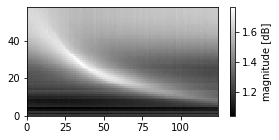

In [11]:
print(X_mean.shape)
fig = plt.figure(figsize=(2*(X_mean.shape[1]/X_mean.shape[0]),2)); 
img = plt.pcolormesh(X_mean, cmap='gray')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.show()

**Save the Kernel**

In [5]:
file_name = os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')
file = h5py.File(file_name, 'w')
file_dataset = file.create_dataset(file_name, X_mean.shape, np.float32, compression='gzip', data=X_mean)
file_dataset.attrs['transforms'] = str(transforms)
file_dataset.attrs['tranforms_params'] = str(transforms_params)
file_dataset.attrs['cut_params'] = str(cut_params)
file.close()

### **Bernard Approximation**

**Generate Kernel**

(59, 120)


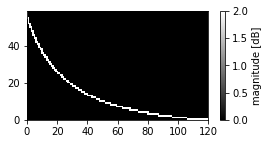

In [6]:
from dataset_simulation import DatasetSimulation
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
An, D0, magnitude = 0.35, 37, 2
data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
print(data.shape)
fig = plt.figure(figsize=(2*data.shape[1]/data.shape[0],2))
img = plt.pcolormesh(data, cmap='gray')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.show()

**Save the Kernel**

In [7]:
file_name = os.path.join(database_loc, site, 'kernels', 'kernel_bernard.h5')
file = h5py.File(file_name, 'w')
file_dataset = file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
file_dataset.attrs['An'] = str(An)
file_dataset.attrs['D0'] = str(D0)
file_dataset.attrs['magnitude'] = str(magnitude)
file.close()